<a href="https://colab.research.google.com/github/MithunW/MachineLearningProject/blob/main/Pump_it_Up_Data_Mining_the_Water_Table_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


## **Importing General Libraries and Test Train Data**

In [181]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train_features = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Training set values.csv')
train_labels = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Training set labels.csv')
test_features = pd.read_csv('/content/gdrive/My Drive/Pump it Up: Data Mining the Water Table/Test set values.csv')

## **Know the Data**

In [182]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [183]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [184]:
X_train=train_features.copy()
y_train=train_labels.copy()
X_train.drop("id",axis=1,inplace=True)
y_train.drop("id",axis=1,inplace=True)

In [185]:
X_train.describe(include='all')

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55523,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Find Missing Values in DataFrame**

In [186]:
print('\nNull Values in Training \n{}'.format(X_train.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_features.isnull().sum()))



Null Values in Training 
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group

In [187]:
#Create list of features in the data set
column_names=list(train_features)
feature_columns=column_names.copy()
feature_columns.remove("id")

In [188]:
#Unique data count of each column in train dataset
X_train.nunique()

amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

## **Solutions for Missing Values in Train and Test Data**

In [189]:
#Drop scheme_name and subvillage since it has lots of missing values and high cardinality
feature_columns.remove("scheme_name")
feature_columns.remove("subvillage")
feature_columns.remove("recorded_by")
feature_columns.remove("date_recorded")
X_train.drop("scheme_name", axis=1, inplace=True)
test_features.drop("scheme_name", axis=1, inplace=True)
X_train.drop("subvillage", axis=1, inplace=True)
test_features.drop("subvillage", axis=1, inplace=True)
X_train.drop("recorded_by", axis=1, inplace=True)
test_features.drop("recorded_by", axis=1, inplace=True)
X_train.drop("date_recorded", axis=1, inplace=True)
test_features.drop("date_recorded", axis=1, inplace=True)

#Fill missing values in funder column with most frequent value of the column
X_train["funder"] = X_train["funder"].fillna("Government Of Tanzania")
test_features["funder"] = test_features["funder"].fillna("Government Of Tanzania")

#Fill missing values in installer column with most frequent value of the column
X_train["installer"] = X_train["installer"].fillna("DWE")
test_features["installer"] = test_features["installer"].fillna("DWE")

#Fill missing values in public_meeting column with most frequent value of the column
X_train["public_meeting"] = X_train["public_meeting"].fillna(True)
test_features["public_meeting"] = test_features["public_meeting"].fillna(True)

#Fill missing values in schema_management column with most frequent value of the column
X_train["scheme_management"] = X_train["scheme_management"].fillna("VWC")
test_features["scheme_management"] = test_features["scheme_management"].fillna("VWC")

#Fill missing values in permit column with most frequent value of the column
X_train["permit"] = X_train["permit"].fillna(True)
test_features["permit"] = test_features["permit"].fillna(True)

# most_frequent_treated_cols=["funder", "installer", "public_meeting", "scheme_management", "permit"]

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
# imputer.fit_transform(X_train[most_frequent_treated_cols])
# imputer.transform(test_features[most_frequent_treated_cols])

print('\nNull Values in Training \n{}'.format(X_train.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_features.isnull().sum()))


Null Values in Training 
amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

Null Values in 

## **Duplicate Values in Train and Test** **Dataset**

In [190]:
print('\nDuplicated values in train {}'.format(X_train.duplicated(subset=feature_columns).sum()))
print('Duplicated values in test {}'.format(test_features.duplicated(subset=feature_columns).sum()))


Duplicated values in train 118
Duplicated values in test 8


In [191]:
#Remove duplicates from the train/test data
X_train["labels"] = y_train
X_train.drop_duplicates(subset=feature_columns, inplace=True)
# X_train.drop("labels",axis=1,inplace=True)

In [192]:
train_visualize = X_train.copy()
train_visualize["status_group"] = train_labels["status_group"]

In [193]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_visualize_encoded = train_visualize.apply(le.fit_transform)

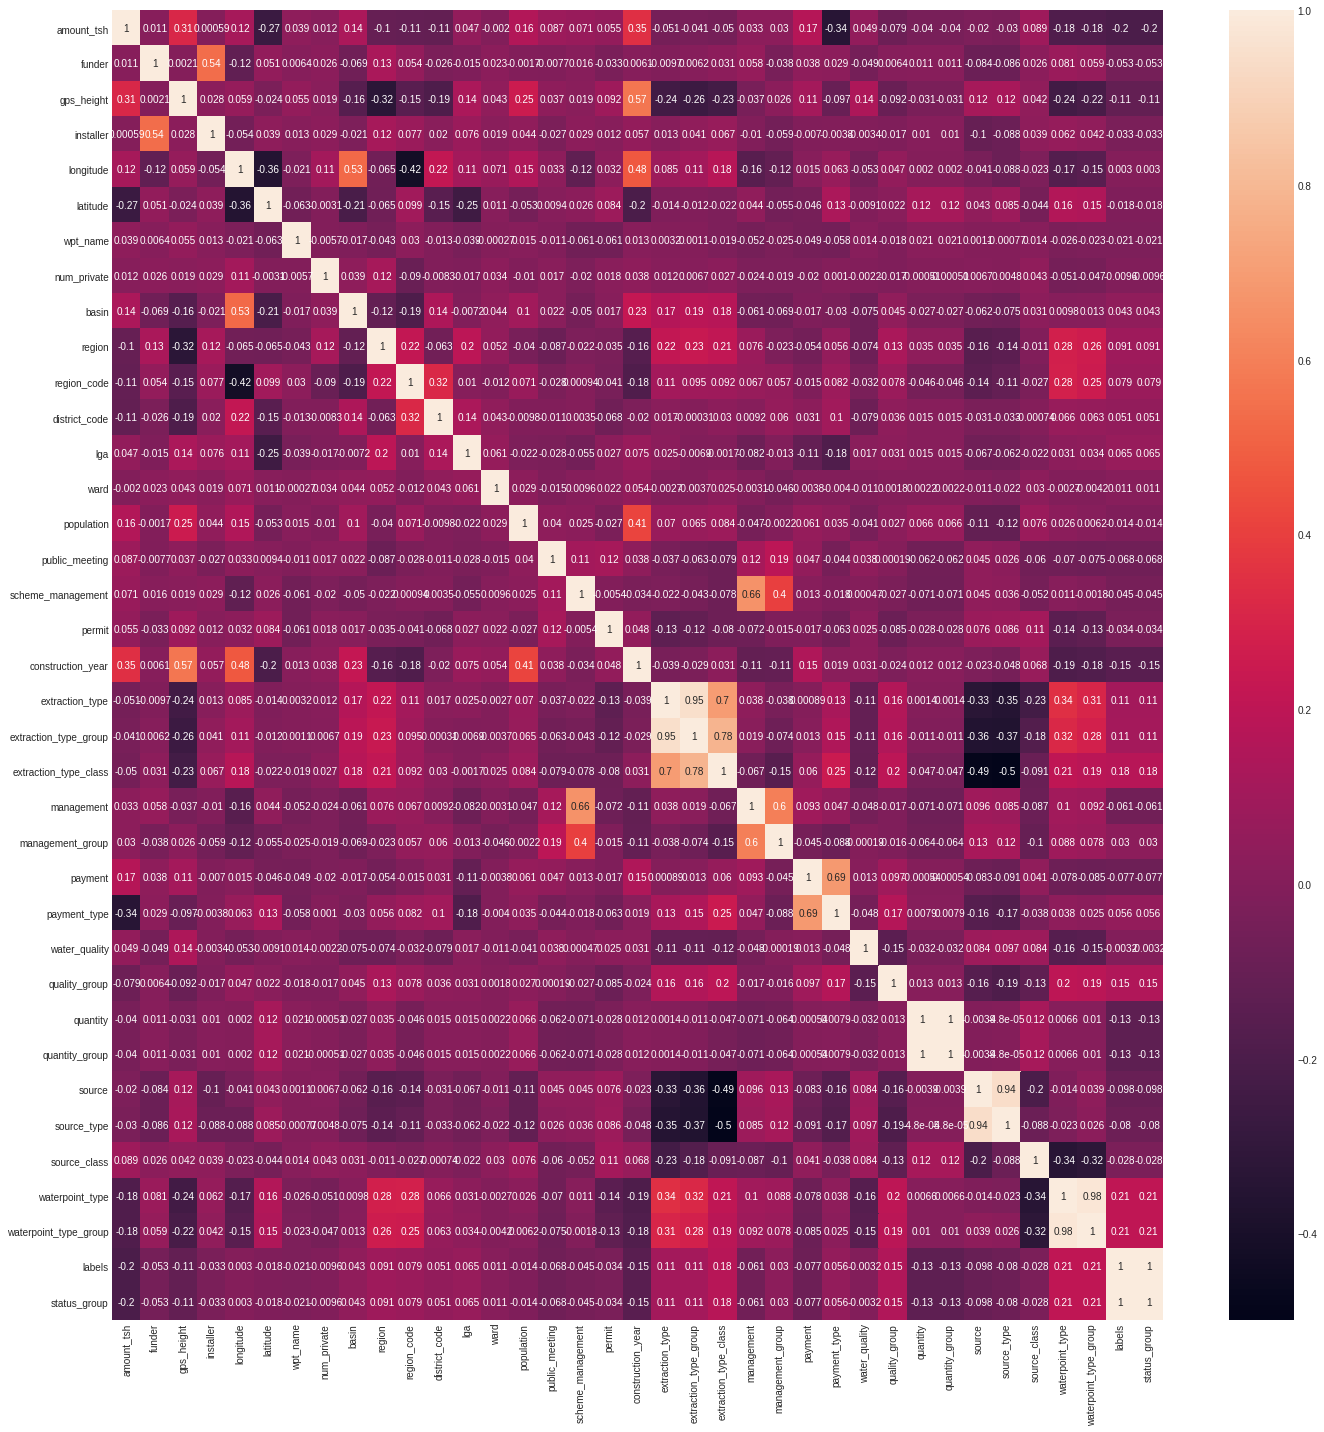

In [194]:
plt.figure(figsize=(20,20))
sns.heatmap(train_visualize_encoded.corr(), annot=True)
plt.tight_layout()

## **Correlation Data**

*   gps_height x construction_year 0.66
*   installer x funder 0.54
*   region_code x district-code 0.68
*   management x scheme_management 0.66
*   extraction_type x extraction_type_group 0.95
*   extraction_type_class x extraction_type 0.7
*   extraction_type_class x extraction_type_group 0.78
*   management_group x management 0.6
*   payment_type x payment 0.69
*   quantity_group x quantity 1
*   source_type x source 0.94
*   waterpoint_type x waterpoint_type_group 0.98 (waterpoint_type contains more details)

Drop one column from correlations more than 0.9
*   extraction_type_group
*   extraction_type
*   quantity_group
*   source_type
*   waterpoint_type_group

Drop more.
*   management x scheme_management 0.66 and schema_management had relatively high count of missing values, Dropping it.
*   payment_type x payment 0.69 lets drop one of them.
*   installer x funder 0.54 has a relatively high correlation. So we are going to remove funder and keep installer.
*   region_code x district-code 0.68 dropping region_code


**Analyzing quantity and quantity_group columns**

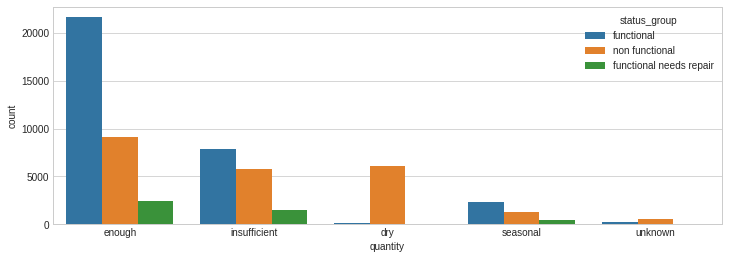

In [195]:
ax = sns.countplot(x='quantity', hue="status_group", data=train_visualize)

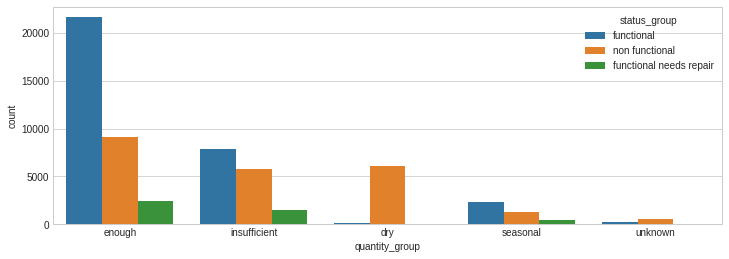

In [196]:

ax = sns.countplot(x='quantity_group', hue="status_group", data=train_visualize)

Conclusing is these two columns have same information

**Analyzing source_class and source columns**


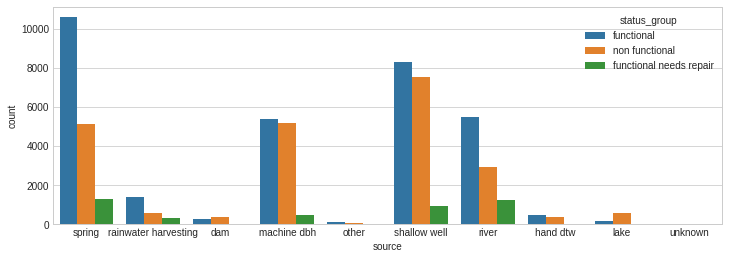

In [197]:
ax = sns.countplot(x='source', hue="status_group", data=train_visualize)

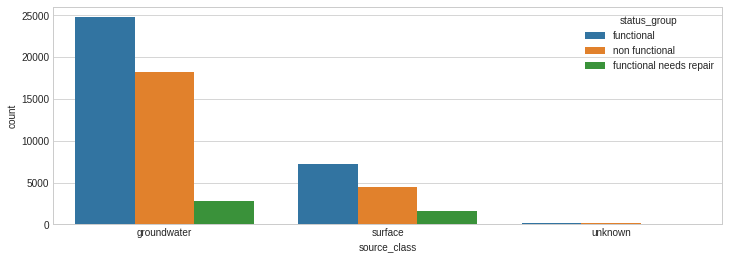

In [198]:
ax = sns.countplot(x='source_class', hue="status_group", data=train_visualize)

As you can clearly see, source_class is a generalized version of source column. Lets keep source column which includes more details and drop source_class columns

**Analyzing water_quality and quality_group**


In [199]:
train_visualize['water_quality'].value_counts()

soft                  50716
salty                  4851
unknown                1866
milky                   804
coloured                490
salty abandoned         338
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [200]:
train_visualize['quality_group'].value_counts()

good        50716
salty        5189
unknown      1866
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

Both columns have same values and water_quality column has more details. So, lets drop quality_group column.

In [201]:
drop_cols=['extraction_type_group','quantity_group', 'funder', 'extraction_type','source_type','waterpoint_type_group','scheme_management','source_class','quality_group','payment_type']
for col in drop_cols:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)

**Feature Engineering to water head and population data**

In [202]:
# X_train["water_population"] = X_train["amount_tsh"]/X_train["population"]
# test_features["water_population"] = test_features["amount_tsh"]/test_features["population"]
# #Fill missing values
# X_train["water_population"] = (X_train["water_population"].fillna(0)).astype({"water_population": 'int32'})
# test_features["water_population"] = (test_features["water_population"].fillna(0)).astype({"water_population": 'int32'})

# drop_cols_water_pop =["amount_tsh","population"]
# for col in drop_cols_water_pop:
#   X_train.drop(col, axis=1, inplace=True)
#   test_features.drop(col, axis=1, inplace=True)
#   feature_columns.remove(col)

In [203]:
X_train

,amount_tsh,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quantity,source,waterpoint_type,labels
0,6000.0,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,False,1999,gravity,vwc,user-group,pay annually,soft,enough,spring,communal standpipe,functional
1,0.0,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,True,2010,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,True,2009,gravity,vwc,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.0,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,True,1986,submersible,vwc,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional
4,0.0,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,True,True,0,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,True,1999,gravity,water board,user-group,pay per bucket,soft,enough,spring,communal standpipe,functional
59396,4700.0,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Iringa,11,4,Njombe,Ikondo,56,True,True,1996,gravity,vwc,user-group,pay annually,soft,enough,river,communal standpipe,functional
59397,0.0,0,DWE,34.017087,-8.750434,Mashine,0,Rufiji,Mbeya,12,7,Mbarali,Chimala,0,True,False,0,handpump,vwc,user-group,pay monthly,fluoride,enough,machine dbh,hand pump,functional
59398,0.0,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,True,0,handpump,vwc,user-group,never pay,soft,insufficient,shallow well,hand pump,functional


Feature Engineering to Population based on the region

In [204]:
# region_frame = pd.concat([lat_long_frame_X,lat_long_frame_y])
# X_train["avg_population"] = (X_train.groupby("region")["population"].transform("mean") 

# customer[["State", "Income", "AverageIncome"]].head(10)

## **construction_year Column**
After training the model once, It is observed that the constructio year is contributing to the model at large. So going to do some feature engineering to construction_year

In [205]:
train_visualize['construction_year'].value_counts()

0       20613
2010     2644
2008     2612
2009     2533
2000     2091
2007     1587
2006     1471
2003     1285
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      944
1996      811
1980      807
1984      779
1982      744
1994      738
1972      708
1974      671
1997      644
1992      640
1993      608
2001      540
1988      520
1983      488
1975      437
1986      433
1976      414
1970      411
1991      323
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      142
1960      101
1967       88
1963       85
1968       75
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Since the construction_year column has high cardinality, going to make it more generalize by changing the year to decades.

In [206]:
X_train['decade'] = X_train['construction_year']
test_features['decade'] = test_features['construction_year']
X_train['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s' , inplace=True)
X_train['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s' , inplace=True)
X_train['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s' , inplace=True)
X_train['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s' , inplace=True)
X_train['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s' , inplace=True)
X_train['decade'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s' , inplace=True)
X_train['construction_year'].replace(to_replace = '0', value = 2000, inplace=True)

test_features['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s' , inplace=True)
test_features['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s' , inplace=True)
test_features['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s' , inplace=True)
test_features['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s' , inplace=True)
test_features['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s' , inplace=True)
test_features['decade'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s' , inplace=True)
test_features['construction_year'].replace(to_replace = '0', value = 2000, inplace=True)

X_train['decade'].value_counts()

0      20613
00s    15328
90s     7677
80s     5571
10s     5160
70s     4398
60s      535
Name: decade, dtype: int64

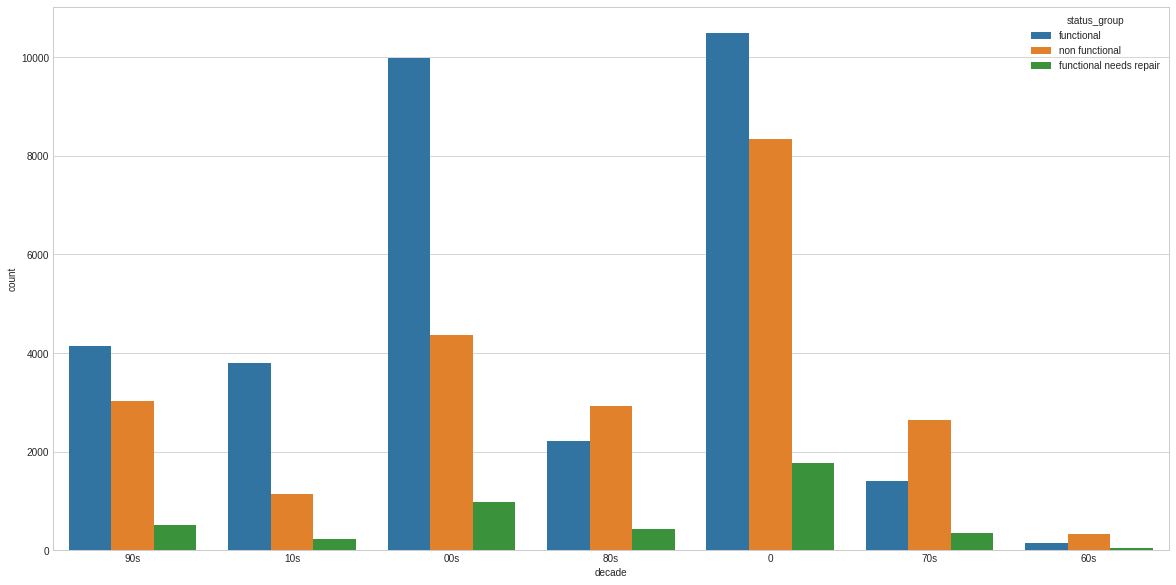

In [207]:
train_visualize['decade'] = X_train['decade']
plt.figure(figsize=(20,10))
ax = sns.countplot(x='decade', hue="status_group", data=train_visualize)

In [208]:
#Then drop the unnecessary construction_year column
X_train.drop("construction_year",axis=1,inplace=True)
test_features.drop("construction_year",axis=1,inplace=True)
X_train.head()

,amount_tsh,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,extraction_type_class,management,management_group,payment,water_quality,quantity,source,waterpoint_type,labels,decade
0,6000.0,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,False,gravity,vwc,user-group,pay annually,soft,enough,spring,communal standpipe,functional,90s
1,0.0,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,True,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,10s
2,25.0,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,00s
3,0.0,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,80s
4,0.0,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,0,True,True,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,0


In [209]:
X_train.nunique()

amount_tsh                  98
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
permit                       2
extraction_type_class        7
management                  12
management_group             5
payment                      7
water_quality                8
quantity                     5
source                      10
waterpoint_type              7
labels                       3
decade                       7
dtype: int64

# **Preprocessing to Outlier values in the dataframe**

In [210]:
id_col = test_features["id"]
test_features.drop("id",axis = 1, inplace=True) 

In [211]:
train_test = pd.concat([X_train, test_features])


### **Population**
Population column has values of 0 which is possible to be an outlier. So I am going to replace them with the mean value of the population column in full dataset.

In [212]:
train_test.loc[train_test['population']!=0].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population
count,47394.000000,47394.000000,47394.000000,47394.000000,47394.000000,47394.000000,47394.000000,47394.000000
mean,447.969797,967.663987,36.078034,-6.140572,0.724311,16.037832,6.300544,283.127569
std,3593.721538,613.056057,2.587997,2.737326,14.434991,21.525104,11.329810,564.522578
min,0.000000,-90.000000,29.607122,-11.649440,0.000000,2.000000,1.000000,1.000000
25%,0.000000,344.000000,34.714810,-8.384809,0.000000,4.000000,2.000000,40.000000
50%,0.000000,1133.000000,36.713864,-5.759823,0.000000,10.000000,3.000000,150.000000
75%,100.000000,1462.000000,37.951684,-3.600309,0.000000,16.000000,5.000000,328.000000
max,350000.000000,2777.000000,40.345193,-1.042375,1776.000000,99.000000,67.000000,30500.000000


In [213]:
train_test['population'].replace(to_replace = 0 , value =283, inplace=True)

### **Longitude**
Longitude also has zero values which should be possible outliers.
We are going to replace them with the mean value.

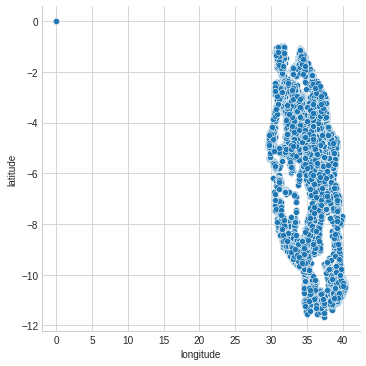

In [214]:
sns.relplot(x="longitude", y="latitude", data=train_test);

In [215]:
train_test.loc[train_test['longitude']!=0].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population
count,71958.000000,71958.000000,71958.000000,71958.000000,71958.000000,71958.000000,71958.000000,71958.000000
mean,328.822557,686.701242,35.147720,-5.881204,0.477056,15.188165,5.728203,283.084021
std,2952.126992,693.382211,2.609010,2.809091,11.719893,17.777787,9.770091,458.143887
min,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,33.277232,-8.633266,0.000000,5.000000,2.000000,90.000000
50%,0.000000,417.000000,35.005982,-5.173059,0.000000,12.000000,3.000000,283.000000
75%,30.000000,1330.000000,37.236372,-3.371722,0.000000,17.000000,5.000000,283.000000
max,350000.000000,2777.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000


In [216]:
train_test['longitude'].replace(to_replace = 0 , value =35.15, inplace=True) 

### **Installer**

In [217]:
train_test['installer'].value_counts()

DWE                           26233
Government                     2268
RWE                            1479
Commu                          1347
DANIDA                         1305
                              ...  
SAXON  BUILDING CONTRACTOR        1
Sua                               1
Boni                              1
KASHERE                           1
Mr Chi                            1
Name: installer, Length: 2410, dtype: int64

Observer that there are lots of unique values in this column, most of them are outliers which are possible spelling mistakes or errors in data gathering. So, fixing them below.

In [218]:
train_test['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

train_test['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
train_test['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

train_test['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                      'District Council','Council','Counc','District  Council','Distri'),
                                    value ='District council' , inplace=True)

train_test['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                      'RC CATHORIC',) , value ='RC Church' , inplace=True)

train_test['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                       'central government','Cental Government', 'Cebtral Government', 
                                      'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                      'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                      'Centra govt') , value ='Central government' , inplace=True)

train_test['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                        value ='world vision' , inplace=True)

train_test['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
train_test['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

train_test['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                      'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                      'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                      'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                      'Village Office','Village community members'),
                                        value ='villagers' , inplace=True)

train_test['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)

train_test['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)

train_test['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)
train_test['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
train_test['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
train_test['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
train_test['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
train_test['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
train_test['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
train_test['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
train_test['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
train_test['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
train_test['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

In [219]:
X_train = (train_test.iloc[:(X_train['installer'].count())])
test_features = (train_test.iloc[(X_train['installer'].count()):])

## **Remove High Cardinality Columns from Dataset**

In [220]:
high_cardinality_cols = ['wpt_name','ward','lga','management_group']
for col in high_cardinality_cols:
  X_train.drop(col, axis=1, inplace=True)
  test_features.drop(col, axis=1, inplace=True)
  feature_columns.remove(col)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [221]:
X_train.head()

,amount_tsh,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,labels,decade
0,6000.0,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,5,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,90s
1,0.0,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Mara,20,2,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,10s
2,25.0,686,world vision,37.460664,-3.821329,0,Pangani,Manyara,21,4,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,00s
3,0.0,263,Unicef,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,80s
4,0.0,0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kagera,18,1,283,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,0


In [222]:
X_train.nunique()

amount_tsh                  98
gps_height                2428
installer                 2054
longitude                57516
latitude                 57517
num_private                 65
basin                        9
region                      21
region_code                 27
district_code               20
population                1048
public_meeting               2
permit                       2
extraction_type_class        7
management                  12
payment                      7
water_quality                8
quantity                     5
source                      10
waterpoint_type              7
labels                       3
decade                       7
dtype: int64

In [223]:
test_features.nunique()

amount_tsh                  68
gps_height                2157
installer                 1037
longitude                14390
latitude                 14390
num_private                 36
basin                        9
region                      21
region_code                 26
district_code               20
population                 636
public_meeting               2
permit                       2
extraction_type_class        7
management                  12
payment                      7
water_quality                8
quantity                     5
source                      10
waterpoint_type              7
labels                       0
decade                       7
dtype: int64

## **Encode Categorical Columns**

In [224]:
X_train

,amount_tsh,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,labels,decade
0,6000.0,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,5,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,90s
1,0.0,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Mara,20,2,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,10s
2,25.0,686,world vision,37.460664,-3.821329,0,Pangani,Manyara,21,4,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,00s
3,0.0,263,Unicef,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,80s
4,0.0,0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kagera,18,1,283,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,CES,37.169807,-3.253847,0,Pangani,Kilimanjaro,3,5,125,True,True,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe,functional,90s
59396,4700.0,1212,Cefa,35.249991,-9.070629,0,Rufiji,Iringa,11,4,56,True,True,gravity,vwc,pay annually,soft,enough,river,communal standpipe,functional,90s
59397,0.0,0,DWE,34.017087,-8.750434,0,Rufiji,Mbeya,12,7,283,True,False,handpump,vwc,pay monthly,fluoride,enough,machine dbh,hand pump,functional,0
59398,0.0,0,Musa,35.861315,-6.378573,0,Rufiji,Dodoma,1,4,283,True,True,handpump,vwc,never pay,soft,insufficient,shallow well,hand pump,functional,0


In [225]:
# from sklearn.preprocessing import OneHotEncoder

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)
object_cols.remove('labels')


# from sklearn.preprocessing import OneHotEncoder

# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
# OH_cols_test = pd.DataFrame(OH_encoder.transform(test_features[object_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train.index
# OH_cols_test.index = test_features.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = X_train.drop(object_cols, axis=1)
# num_X_test = test_features.drop(object_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [226]:
import pandas
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
print("Row count in X_train dataframe= "+ str(X_train['source'].count()))
print("Row count in test dataframe= "+ str(test_features['source'].count()))

full_data_set = pd.concat([X_train[object_cols],test_features[object_cols]])

for col in object_cols:
  full_data_set[col] = pd.factorize(full_data_set[col])[0]

X_train[object_cols] = (full_data_set[object_cols].iloc[:(X_train['source'].count())]).astype(int)
test_features[object_cols] = (full_data_set[object_cols].iloc[(X_train['source'].count()):]).astype(int)

Row count in X_train dataframe= 59282
Row count in test dataframe= 14850


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [227]:
def modelfit(alg, dtrain, predictors, useTrainCV=False, cv_folds=10, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target],dtrain_predprob,multi_class='ovr',labels=dtrain[target]))
    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [228]:
X_train['labels'] = X_train['labels'].map({'functional':0,'functional needs repair':1,'non functional':2})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [229]:
X_train

,amount_tsh,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,labels,decade
0,6000.0,1390,0,34.938093,-9.856322,0,0,0,11,5,109,True,False,0,0,0,0,0,0,0,0,0
1,0.0,1399,1,34.698766,-2.147466,0,1,1,20,2,280,True,True,0,1,1,0,1,1,0,0,1
2,25.0,686,2,37.460664,-3.821329,0,2,2,21,4,250,True,True,0,0,2,0,0,2,1,0,2
3,0.0,263,3,38.486161,-11.155298,0,3,3,90,63,58,True,True,1,0,1,0,2,3,1,2,3
4,0.0,0,4,31.130847,-1.825359,0,1,4,18,1,283,True,True,0,2,1,0,3,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,46,37.169807,-3.253847,0,2,10,3,5,125,True,True,0,4,2,0,0,0,0,0,0
59396,4700.0,1212,969,35.249991,-9.070629,0,7,0,11,4,56,True,True,0,0,0,0,0,6,0,0,0
59397,0.0,0,5,34.017087,-8.750434,0,7,17,12,7,283,True,False,2,0,6,4,0,3,2,0,4
59398,0.0,0,450,35.861315,-6.378573,0,7,15,1,4,283,True,True,2,0,1,0,1,5,2,0,4


In [230]:
test_features

,amount_tsh,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,labels,decade
0,0.0,1996,309,35.290799,-4.059696,0,4,2,21,3,321,True,True,3,8,1,0,3,1,3,NaN,1
1,0.0,1569,5,36.656709,-3.309214,0,2,16,2,2,300,True,True,0,0,1,0,1,0,0,NaN,2
2,0.0,1567,5,34.767863,-5.004344,0,4,18,13,2,500,True,True,3,0,1,0,1,1,3,NaN,1
3,0.0,267,116,38.058046,-9.418672,0,3,14,80,43,250,True,True,3,0,3,0,2,5,3,NaN,3
4,500.0,1260,1063,35.006123,-10.950412,0,3,9,10,3,60,True,True,0,4,6,0,0,0,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.0,34,277,38.852669,-6.582841,0,6,8,6,1,20,True,True,4,0,1,0,0,6,0,NaN,3
14846,1000.0,0,682,37.451633,-5.350428,0,2,5,4,7,2960,True,False,2,0,0,1,1,5,2,NaN,0
14847,0.0,1476,5,34.739804,-4.585587,0,4,18,13,2,200,True,True,0,0,1,0,1,2,0,NaN,1
14848,0.0,998,5,35.432732,-10.584159,0,0,9,10,2,150,True,True,0,0,1,0,1,6,0,NaN,2


In [231]:
from sklearn.preprocessing import StandardScaler
target = "labels"
predictors = [x for x in X_train.columns if x not in ["labels"]]
scaler = StandardScaler()
X_train[predictors] = scaler.fit_transform(X_train[predictors])
test_features[predictors] = scaler.transform(test_features[predictors])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio


Model Report
Accuracy : 0.8184


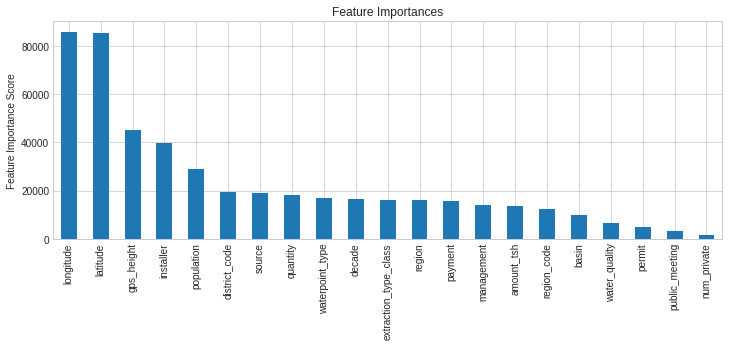

In [232]:
from xgboost.sklearn import XGBClassifier
target = "labels"
predictors = [x for x in X_train.columns if x not in ["labels"]]


xgb4 = XGBClassifier(
 learning_rate =0.005,
 n_estimators=4000,
 max_depth=6,
 min_child_weight=6,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.004,
 objective= 'multi:softmax',
 num_class = 3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb4, X_train, predictors, early_stopping_rounds=200)

In [233]:
test_pred = xgb4.predict(test_features[predictors])
print(pd.DataFrame(test_pred).value_counts())
result_array = pd.DataFrame(np.array([test_pred]).T, columns=['status_group'])
results = id_col
results_mapped=result_array['status_group'].map({0:'functional',1:'functional needs repair',2:'non functional'})
final_result=pd.concat([results, results_mapped], axis=1)
final_result.to_csv('predictions-xgb.csv', index=False)

0    9655
2    4858
1     337
dtype: int64


In [234]:
xgb1 = XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=100,gamma=0.2)
xgb1.fit(X_train[predictors], X_train['labels'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [235]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=1)
rfc1.fit(X_train[predictors], X_train['labels'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [236]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = cross_val_score(xgb1, X_train[predictors], X_train['labels'], cv=10, scoring='accuracy')
scores

array([0.80873672, 0.80772474, 0.8041498 , 0.79976383, 0.81207827,
       0.79689609, 0.80566802, 0.80026991, 0.79402834, 0.81207827])

In [237]:
scores = cross_val_score(rfc1, X_train[predictors], X_train['labels'], cv=10, scoring='accuracy')
scores

array([0.7377298 , 0.7417777 , 0.73397436, 0.73599865, 0.74578273,
       0.73566127, 0.74274629, 0.73397436, 0.74038462, 0.7537112 ])

In [238]:


test_pred = xgb1.predict(test_features[predictors])
print(pd.DataFrame(test_pred).value_counts())
result_array = pd.DataFrame(np.array([test_pred]).T, columns=['status_group'])
results = id_col
results_mapped=result_array['status_group'].map({0:'functional',1:'functional needs repair',2:'non functional'})
final_result=pd.concat([results, results_mapped], axis=1)
final_result.to_csv('predictions-xgb1.csv', index=False)

0    9255
2    5119
1     476
dtype: int64
